In [9]:
import matplotlib.pyplot as plt
import os
import cv2
import sys
from scipy import io
import pandas as pd
from scipy.spatial import distance
import numpy as np
import math


def ASTM_E399(Pq,a,B,W):
    """B is thickness(cm), W is width(cm), Pq is stress(kN), A is crack length(cm)"""
    f_in = a/W
    f=((2+f_in)*(0.886+4.64*f_in-13.32*(f_in**2)+14.72*(f_in**3)-5.6*(f_in**4)))/((1-f_in)**1.5)
    kq=(Pq*f)/(B*(W**0.5))
    return kq

def hookes_law_sigmayy(YoungsModulus, Poisson, strain_xx, strain_yy):
    sigma_yy = YoungsModulus*(strain_xx*Poisson + strain_yy)/(1-Poisson**2)
    return sigma_yy

def Williams_sigmayy(r, theta):
    theta = math.radians(theta)
    K1_coefficient = np.cos(theta/2) * (1 + np.sin(theta/2) * np.sin(3 * theta / 2)) / (2 * np.pi * r) ** 0.5
    K2_coefficient = np.sin(theta/2) * np.cos(theta/2) * np.cos(3*theta/2) / (2 * np.pi * r) ** 0.5
    return [K1_coefficient, K2_coefficient]

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    degree = math.degrees(phi)
    return(rho, degree)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

def make_mask(path, num):
    class PolygonDrawer(object):
        def __init__(self, window_name):
            self.window_name = window_name # Name for our window
            self.done = False # Flag signalling we're done
            self.current = (0, 0) # Current position, so we can draw the line-in-progress
            self.points = [] # List of points defining our polygon

        def on_mouse(self, event, x, y, buttons, user_param):
            # Mouse callback that gets called for every mouse event (i.e. moving, clicking, etc.)
            if self.done: # Nothing more to do
                return
            if event == cv2.EVENT_MOUSEMOVE:
                # We want to be able to draw the line-in-progress, so update current mouse position
                self.current = (x, y)
            elif event == cv2.EVENT_LBUTTONDOWN:
                # Left click means adding a point at current position to the list of points
                # print("Adding point #%d with position(%d,%d)" % (len(self.points), x, y))
                self.points.append((x, y))
            elif event == cv2.EVENT_RBUTTONDOWN:
                # Right click means we're done
                print("Completing polygon with %d points." % len(self.points))
                self.done = True


        def run(self):
            # Let's create our working window and set a mouse callback to handle events
            cv2.namedWindow(self.window_name)
            cv2.imshow(self.window_name, np.zeros(CANVAS_SIZE, np.uint8))
            cv2.waitKey(1)
            cv2.setMouseCallback(self.window_name, self.on_mouse)

            while(not self.done):
                # This is our drawing loop, we just continuously draw new images
                # and show them in the named window
                canvas = image
                if (len(self.points) > 0):
                    # Draw all the current polygon segments
                    cv2.polylines(canvas, np.array([self.points]), False, (255, 255, 255), 1)
                    # And  also show what the current segment would look like
                    # cv2.line(canvas, self.points[-1], self.current, WORKING_LINE_COLOR)
                # Update the window
                cv2.imshow(self.window_name, canvas)
                # And wait 50ms before next iteration (this will pump window messages meanwhile)
                if cv2.waitKey(50) == 27: # ESC hit
                    self.done = True

            # User finised entering the polygon points, so let's make the final drawing
            canvas = image
            # of a filled polygon
            if (len(self.points) > 0):
                cv2.fillPoly(canvas, np.array([self.points]), (255, 255, 255))
                # print(np.array([self.points]))

            # And show it
            cv2.imshow(self.window_name, canvas)
            # Waiting for the user to press any key
            cv2.waitKey()
            cv2.destroyWindow(self.window_name)

            return canvas, self.points

    file_list = os.listdir(path)
    img = [file for file in file_list if file.endswith(".jpg")]
    image = cv2.imread(path+'/'+img[num], cv2.IMREAD_GRAYSCALE)

    if image is None:
        print('Image load failed!')
        sys.exit()
    x, y, w, h = cv2.selectROI(image)
    cv2.destroyAllWindows()

    cv2.rectangle(image, (x,y), (x+w,y+h),(0,0,0),2)
    CANVAS_SIZE = np.shape(image)

    poly = PolygonDrawer("Polygon")
    _, poly_points = poly.run()

    ##mask part
    mask = np.zeros(np.shape(image))
    mask[y:y+h, x:x+w] = 255
    cv2.fillPoly(mask, np.array([poly_points]), (0,0,0))
    cv2.imshow('mask', mask)

    #%% save part
    cv2.imwrite(path+'/'+str(num)+'.png',mask)
    cv2.waitKey()
    cv2.destroyAllWindows()

    return x, y ,w ,h



class Crack_tip():
    def __init__(self, ratio):
        """ x, y 는 좌표, point 는 리스트로 x,y좌표 모아줌, count는 좌표 몇개, 길이, 1픽셀당 mm(mm/1픽셀)"""
        self.x = 0
        self.y =0
        self.point = []
        self.count= -1
        self.length = 0
        self.ratio = ratio
        self.df = pd.DataFrame(index = range(0,3), columns=['index', 'length',  'length(add)', 'x', 'y'])
        return

    def inital(self, x, y):
        self.x = x
        self.y= y
        self.point.append([[x,y]])
        self.df.loc[0] = [self.count+1, 0 , 0 , x, y]
        self.count +=1


    def append(self, x, y):
        self.x =x
        self.y= y
        self.point.append([[x,y]])
        self.count +=1
        self.length = distance.cdist(self.point[self.count-1], self.point[self.count]) * self.ratio
        self.df.loc[self.count] = [self.count, self.length ,self.length + self.df["length(add)"][self.count-1], x, y]


    def position(self):
        return self.point

    def all_position(self):
        return self.df
    pass

In [8]:
crack = Crack_tip(0.03)
crack.inital(500,600)
crack.all_position()

Enter initial position
done


In [11]:

"""
step1. make mask reference, current

"""


path = r'C:\Users\ghrms\Desktop\DIC'
ref_xywh = make_mask(path, 0)
cur_xywh = make_mask(path, 1) #path, image number in folder

(79, 59)


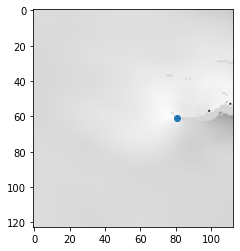

array([[ 88.72946865],
       [-55.01518115]])

In [311]:

"""

#mat save code
exx = handles_ncorr.data_dic.strains.plot_exx_cur_formatted
eyy = handles_ncorr.data_dic.strains.plot_eyy_cur_formatted
roi_cur = handles_ncorr.data_dic.strains.roi_cur_formatted
"""


mat_path = 'E:\experiment data/aluminum/2021-01-27/0.05mmsec_125f_epoxy_dic/dic_mat/'
exx = io.loadmat(mat_path+'num8_exx.mat')['exx']
eyy = io.loadmat(mat_path+'num8_eyy.mat')['eyy']

[[-10.  -0.]
 [-10.  -2.]
 [ -9.  -3.]
 [ -9.  -5.]
 [ -8.  -6.]
 [ -6.  -8.]
 [ -5.  -9.]
 [ -3.  -9.]
 [ -2. -10.]
 [  0. -10.]
 [  2. -10.]
 [  3.  -9.]
 [  5.  -9.]
 [  6.  -8.]
 [  8.  -6.]
 [  9.  -5.]
 [  9.  -3.]
 [ 10.  -2.]
 [ 10.   0.]
 [ 10.   2.]
 [  9.   3.]
 [  9.   5.]
 [  8.   6.]
 [  6.   8.]
 [  5.   9.]
 [  3.   9.]
 [  2.  10.]
 [  0.  10.]
 [ -2.  10.]
 [ -3.   9.]
 [ -5.   9.]
 [ -6.   8.]
 [ -8.   6.]
 [ -9.   5.]
 [ -9.   3.]
 [-10.   2.]
 [-10.   0.]]


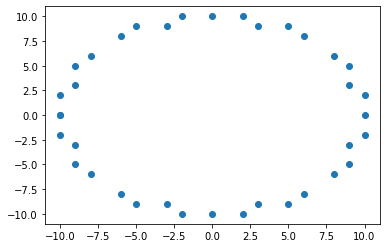

In [75]:
import numpy as np
import matplotlib.pyplot as plt

def cart2pol(x, y):
    """out put : dgree, rho"""
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    degree = np.rad2deg(phi).reshape([-1,1])
    out = np. hstack((rho,degree))
    return out

def pol2cart(rho, degree):
    """in put : degree, rho"""
    phi = np.deg2rad(degree).reshape([-1,1])
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    out = np.hstack((x, y))
    return out

radius = 10
degree = np.arange(-180, 180+10 ,10)
degree.reshape([-1,1])
rho = np.ones([degree.shape[0],1]) * radius

print(pol2cart(rho, degree).round())
x = pol2cart(rho, degree).round()[:,0]
y = pol2cart(rho, degree).round()[:,1]

plt.scatter(x, y)
